In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
mpl.rcParams["mathtext.fontset"] = "stix"


In [91]:
# %run -i 'load_data.py'

In [18]:
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import rpy2
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as rpyn
from statsmodels.stats.multitest import multipletests
dt = rpy2.robjects.packages.importr('diptest')

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.special import logit
from scipy.special import expit

from sklearn.metrics import adjusted_rand_score

from scipy.stats import chisquare

from scipy.stats import hypergeom
def hyper_test(M, n, N, k):
    
    hpd = hypergeom(M, n, N)
    p_depleted = hpd.cdf(k)
    p_enriched = hpd.sf(k-1)
    
    return p_depleted, p_enriched


from scipy.stats import probplot

In [19]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi[1] >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    if correct_multitest:
        pvals_adj = multipletests(pvals, method=correction)[1]
    else:
        pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals_adj

    
    
    
def test_exon_chi(PSI_tab, exon, clusters, psi_lim = 0.5):
    chi_pos = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= psi_lim).sum()
        missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = len(cluster_cells) - pos_cases - missing
        
        chi_pos.append(pos_cases)
        chi_neg.append(neg_cases)
        
#     print(chi_pos)
#     print(chi_neg)
        
    return chisquare(chi_pos, chi_neg), np.array(chi_pos), np.array(chi_neg)


def test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
        
    return chisquare(chi_pos, chi_exp)[1], np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)


def get_osm(lista, index):
    n = len(lista)
    dframe = pd.DataFrame()
    dframe['lista'] = lista
    dframe_sorted = dframe.sort_values('lista')
    dframe_sorted['rank'] = np.array(range(n)) + 1
    dframe = dframe_sorted.loc[dframe.index]
#     np.array(dframe.sort_values('lista').index) + 1
#     dframe['rank'] = dframe_sorted
    
    val_list = []
    for idx in dframe.index:
        i = dframe.loc[idx, 'rank']
        if i == 1:
#             print('first')
            val = 1-0.5**(1/n)
        elif i == n:
#             print('last')
            val = 0.5**(1/n)
        else:
            val = (i - 0.3175) / (n + 0.365)
            
        val_list.append(val)
    dframe['val'] = val_list
    quantiles = norm.ppf(val_list)
    dframe['quantiles'] = quantiles
    
    dframe.index = index
    
    return dframe

In [109]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
#     joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads, chi_p_reads = cluster_chi_test(aver_all_reads[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    osm_1 = get_osm(chi_p, change_tab.index)
    joint_idx = osm_1.index
    
    if filter_obs:
        osm_2 = get_osm(chi_p_reads, change_tab_reads.index)
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle('p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle('p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,11)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    if not filter_obs:
        ax_marg_x5 = fig.add_subplot(gs[0:6,10])
        ax_marg_x5.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    
    
#     ax_joint.scatter(probplot(osm_1.lista, dist='uniform')[0][0], 
#                      probplot(osm_1.lista, dist='uniform')[0][1], 
#                      alpha = 0.5, c='purple', label='all')
    
    if filter_obs:
        
        ax_joint.scatter(probplot(osm_1.loc[[x for x in change_tab.index if x not in aver[0].index], 'lista'], dist='uniform')[0][0], 
                     probplot(osm_1.loc[[x for x in change_tab.index if x not in aver[0].index], 'lista'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
#         print(list(osm_1.loc[[x for x in change_tab.index if x not in aver[0].index], 'lista']))
        
        ax_joint.scatter(probplot(osm_2.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'lista'], 
                                  dist='uniform')[0][0], 
                     probplot(osm_2.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'lista'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        ax_joint.scatter(probplot(osm_1.loc[[x for x in change_tab.index if x in aver[0].index], 'lista'], dist='uniform')[0][0], 
                         probplot(osm_1.loc[[x for x in change_tab.index if x in aver[0].index], 'lista'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
        
        
        ax_joint.scatter(probplot(osm_2.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'lista'], dist='uniform')[0][0], 
                         probplot(osm_2.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'lista'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
    
    
#     ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], dist='uniform')[0][0], 
#                      probplot(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], dist='uniform')[0][1], 
#                      alpha = 0.5, c='navy', label='rejected')
    
    else:
        ax_joint.scatter(probplot(osm_1.lista, dist='uniform')[0][0], 
                     probplot(osm_1.lista, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')
        
        ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x in aver[0].index], 'lista'], dist='uniform')[0][0], 
                         probplot(osm_1.loc[[x for x in joint_idx if x in aver[0].index], 'lista'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
        
        ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], dist='uniform')[0][0], 
                     probplot(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], dist='uniform')[0][0], 
                         probplot(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')

        ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'], dist='uniform')[0][0], 
                         probplot(osm_1.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')

    
#     ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'])[0][0], 
#                      probplot(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'])[0][1], 
#                      alpha = 0.5, c='forestgreen', label='rejected reads')
    
#     ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'])[0][0], 
#                      probplot(osm_1.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'])[0][1], 
#                      alpha = 0.5, c='darkorange', label='selected reads')
    
    
    
    
#     ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
#                osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.5,
#                     label='rejected')
    
#     ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
#                osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.5, 
#                      label='selected')
    
    ax_joint.plot([-0.05, 1], [0.05, 0.05], 'r--')
    
#     ax_marg_x3.hist(chi_p, orientation="horizontal", color='purple', bins=20)
#     ax_marg_x1.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
#                     orientation="horizontal", color='red', bins=20)
#     ax_marg_x2.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
#                     orientation="horizontal", color='navy', bins=20)
    
    if filter_obs:
        ax_marg_x1.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x2.hist(osm_1.loc[[x for x in joint_idx if x in aver[0].index], 'lista'], 
                        orientation="horizontal", color='red', bins=20)
        
        
        ax_marg_x3.hist(osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x4.hist(osm_2.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
#         ax_marg_x2.hist(chi_p_reads, orientation="horizontal", color='purple', bins=20)
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(osm_1.shape)
    
    N = len([x for x in aver[0].index if x in osm_1.index])
    k = (osm_1.loc[[x for x in aver[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in osm_2.index])
        k = (osm_2.loc[[x for x in aver_reads[0].index if x in osm_2.index], 'lista'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in osm_1.index])
        k = (osm_1.loc[[x for x in aver_reads[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
27


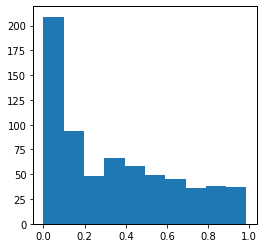

(680, 6)


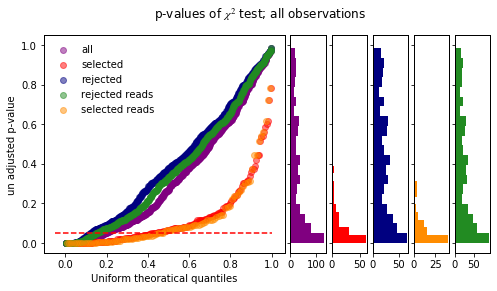

(680, 4)
filter
680
131
157
66
(0.9999999999991362, 9.348899643261109e-15)
reads
680
131
92
42
(0.9999999999405351, 2.909652460926646e-10)


In [110]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
581


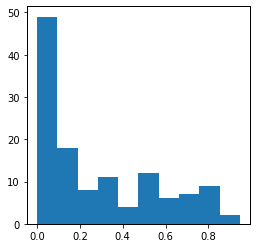

not pass
567


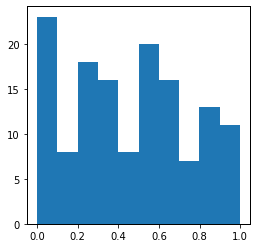

(126, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


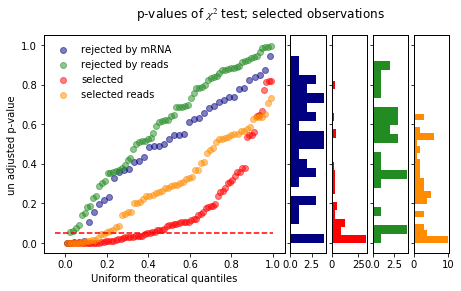

(126, 4)
filter
126
39
85
35
(0.9999733367687581, 0.00019118958112307376)
reads
140
14
68
13
(0.999981068880479, 0.0003658869101354098)


In [111]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs=True)

492
(497, 513)
(611, 513)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
10


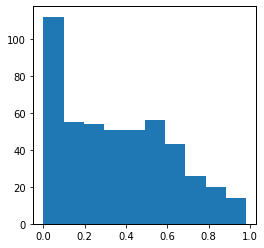

(482, 4)


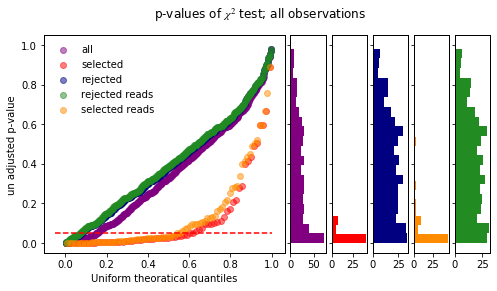

(482, 4)
filter
482
73
67
40
(1.0, 6.489545326911521e-21)
reads
482
73
82
44
(1.0, 8.112723158431036e-21)


In [112]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, 
                 lescroart_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
21


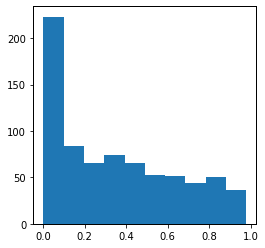

(746, 4)


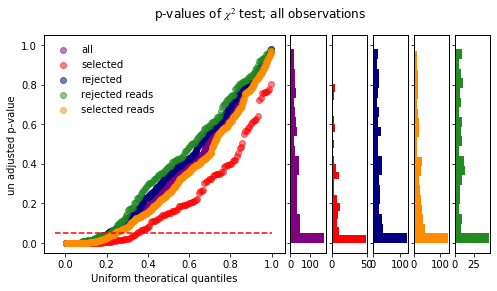

(746, 4)
filter
746
175
146
50
(0.9997025620708399, 0.0006221467803456282)
reads
746
175
540
130
(0.7689739221325559, 0.29450603584192325)


In [113]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10)

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
182


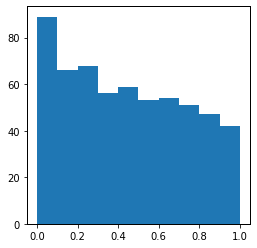

not pass
16


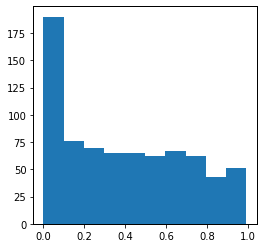

(585, 4)


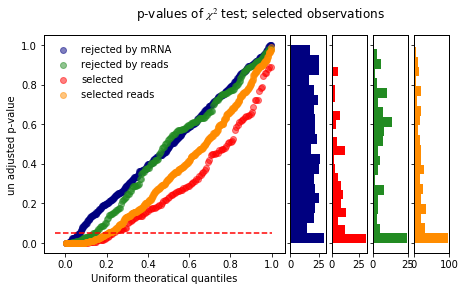

(585, 4)
filter
585
63
144
33
(0.999999903728899, 4.135873634391211e-07)
reads
751
144
541
113
(0.9798669291521832, 0.03322925351370645)


In [114]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10, filter_obs=True)

241
(241, 231)
(242, 231)
not pass
0


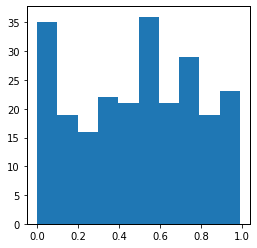

(241, 5)


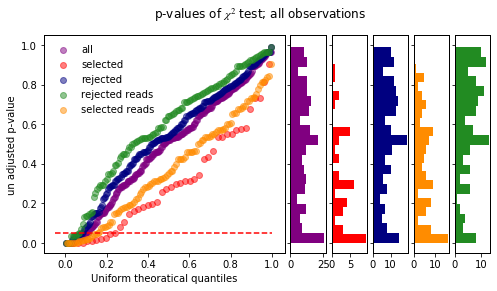

(241, 4)
filter
241
26
44
11
(0.9995343055849283, 0.002158251666432886)
reads
241
26
113
18
(0.995925255561197, 0.013279418650192729)


In [115]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                 trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 6, read_min =10)

241
(241, 231)
(242, 231)
not pass
0


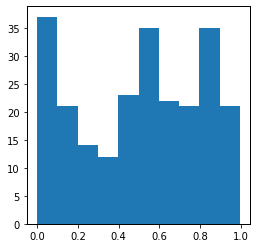

(241, 5)


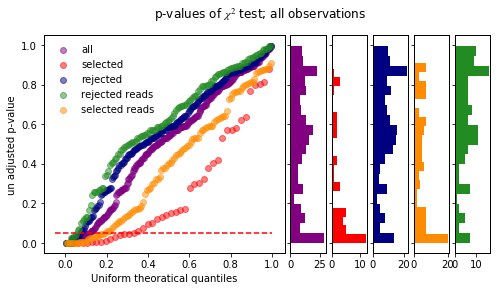

(241, 4)
filter
241
29
44
15
(0.999998552778137, 1.0751324038548351e-05)
reads
241
29
113
22
(0.9998369410150804, 0.0007555716771733699)


In [116]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                 trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 6, read_min =10)